In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_fscore_support, confusion_matrix, pairwise_distances
from sklearn.ensemble import StackingClassifier, VotingClassifier
from scipy.spatial.distance import squareform
import pickle
import pandas as pd


In [24]:
df=pd.read_csv('Base_tratada\\database.csv')
df.dropna(subset=['Conteudo_filtrado'],inplace=True)
df[df['Categoria'] =='entertainment']


,Conteudo_filtrado,Categoria,Id,Conteudo


In [23]:
# Codificação da categoria
le = LabelEncoder()
df['Classification'] = le.fit_transform(df['Categoria'])

# Determina o mínimo número de ocorrências de uma categoria
minimum_count = df['Categoria'].value_counts().min()

# Shuffle dos dados
df = df.sample(frac=1)

# Seleção das amostras balanceadas por categoria
politics_df = df.loc[df['Categoria'] == 'Politics'][:minimum_count]
crime_df = df.loc[df['Categoria'] == 'Crime'][:minimum_count]
entertainment_df = df.loc[df['Categoria'] == 'Entertainment'][:minimum_count]
science_df = df.loc[df['Categoria'] == 'Science'][:minimum_count]
normal_dist_df = pd.concat([politics_df, crime_df, entertainment_df, science_df])

# Vetorização
tfidf = TfidfVectorizer(lowercase=False)
train_vec = tfidf.fit_transform(normal_dist_df['Conteudo_filtrado'])
print(train_vec.shape)

normal_dist_df[normal_dist_df['Categoria'] =='entertainment']


(3276, 31323)


,Conteudo_filtrado,Categoria,Id,Conteudo,Classification


In [4]:
teste_size=0.2

X_train, X_test, y_train, y_test = train_test_split(train_vec, normal_dist_df['Classification'], stratify=normal_dist_df['Classification'], test_size=teste_size)

print("x_train", X_train.shape, type(X_train))
print("X_test", X_test.shape, type(X_test))
print("y_train", y_train.shape, type(y_train))
print("y_test", y_test.shape, type(y_test))

x_train (2620, 30772) <class 'scipy.sparse._csr.csr_matrix'>
X_test (656, 30772) <class 'scipy.sparse._csr.csr_matrix'>
y_train (2620,) <class 'pandas.core.series.Series'>
y_test (656,) <class 'pandas.core.series.Series'>


In [5]:
classifiers = {
    "SVC": SVC(probability=True),
    "LR": LogisticRegression(max_iter= 500),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier()
}

In [6]:
n_split = 5
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=n_split)
    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score.")
    
  

Classifiers:  SVC Has a training score of 92.0 % accuracy score.
Classifiers:  LR Has a training score of 92.0 % accuracy score.
Classifiers:  KNN Has a training score of 89.0 % accuracy score.
Classifiers:  DT Has a training score of 74.0 % accuracy score.


In [7]:
method = 'predict_proba'
n_split = 5
log_reg_pred = cross_val_predict(classifiers["LR"], X_train, y_train, cv = n_split, method = method)
knn_pred = cross_val_predict(classifiers["KNN"], X_train, y_train, cv = n_split, method = method)
svc_pred = cross_val_predict(classifiers["SVC"], X_train, y_train, cv = n_split, method = method)
tree_pred = cross_val_predict(classifiers["DT"], X_train, y_train, cv = n_split, method = method)



In [8]:
log_reg_auc_score = roc_auc_score(y_train, log_reg_pred, multi_class = 'ovr')
knn_auc_score = roc_auc_score(y_train, knn_pred, multi_class = 'ovr')
svc_auc_score = roc_auc_score(y_train, svc_pred, multi_class = 'ovr')
tree_auc_score = roc_auc_score(y_train, tree_pred, multi_class = 'ovr')

print('Support Vector Classifier AUC: ', svc_auc_score)
print('Logistic Regression AUC: ', log_reg_auc_score)
print('KNears Neighbors AUC: ', knn_auc_score)
print('Decision Tree Classifier AUC: ', tree_auc_score)

Support Vector Classifier AUC:  0.9868491667165641
Logistic Regression AUC:  0.9855933568225012
KNears Neighbors AUC:  0.9735783726234297
Decision Tree Classifier AUC:  0.8090642976771343


In [9]:
method = 'predict'
n_split = 5
log_reg_pred = cross_val_predict(classifiers["LR"], X_test, y_test, cv = n_split, method = method)
knn_pred = cross_val_predict(classifiers["KNN"], X_test, y_test, cv = n_split, method = method)
svc_pred = cross_val_predict(classifiers["SVC"], X_test, y_test, cv = n_split, method = method)
tree_pred = cross_val_predict(classifiers["DT"], X_test, y_test, cv = n_split, method = method)

In [10]:
log_reg_cf = confusion_matrix(y_test, log_reg_pred)
kneighbors_cf = confusion_matrix(y_test, knn_pred)
svc_cf = confusion_matrix(y_test, svc_pred)
tree_cf = confusion_matrix(y_test, tree_pred)

In [11]:
!pip install nbformat>=4.2.0


In [12]:
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
x= ['FP','TN']
y= ['TP','FN']
colorscale = [[0, 'rgb(255,0,0)'], [1, 'rgb(0,0,255)']]

conf_matrix = make_subplots(rows=2, cols=2, subplot_titles=("Logistic Regression", "K-Nearest Neighbor", "Support Vector Classifier", "Decision Tree Classifier"))
conf_matrix.add_heatmap(y=y, colorscale=colorscale, texttemplate="%{text}", textfont={"size":20}, z=log_reg_cf, text=log_reg_cf, row=1, col=1)
conf_matrix.add_heatmap(x=x, y=y, colorscale=colorscale, texttemplate="%{text}", textfont={"size":20}, showscale=False, z=kneighbors_cf, text=kneighbors_cf, row=1, col=2)
conf_matrix.add_heatmap(x=x, y=y, colorscale=colorscale, texttemplate="%{text}", textfont={"size":20}, showscale=False, z=svc_cf, text=svc_cf, row=2, col=1)
conf_matrix.add_heatmap(x=x, y=y, colorscale=colorscale, texttemplate="%{text}", textfont={"size":20}, showscale=False, z=tree_cf, text=tree_cf, row=2, col=2)

conf_matrix.update_yaxes(autorange="reversed")
conf_matrix.show()

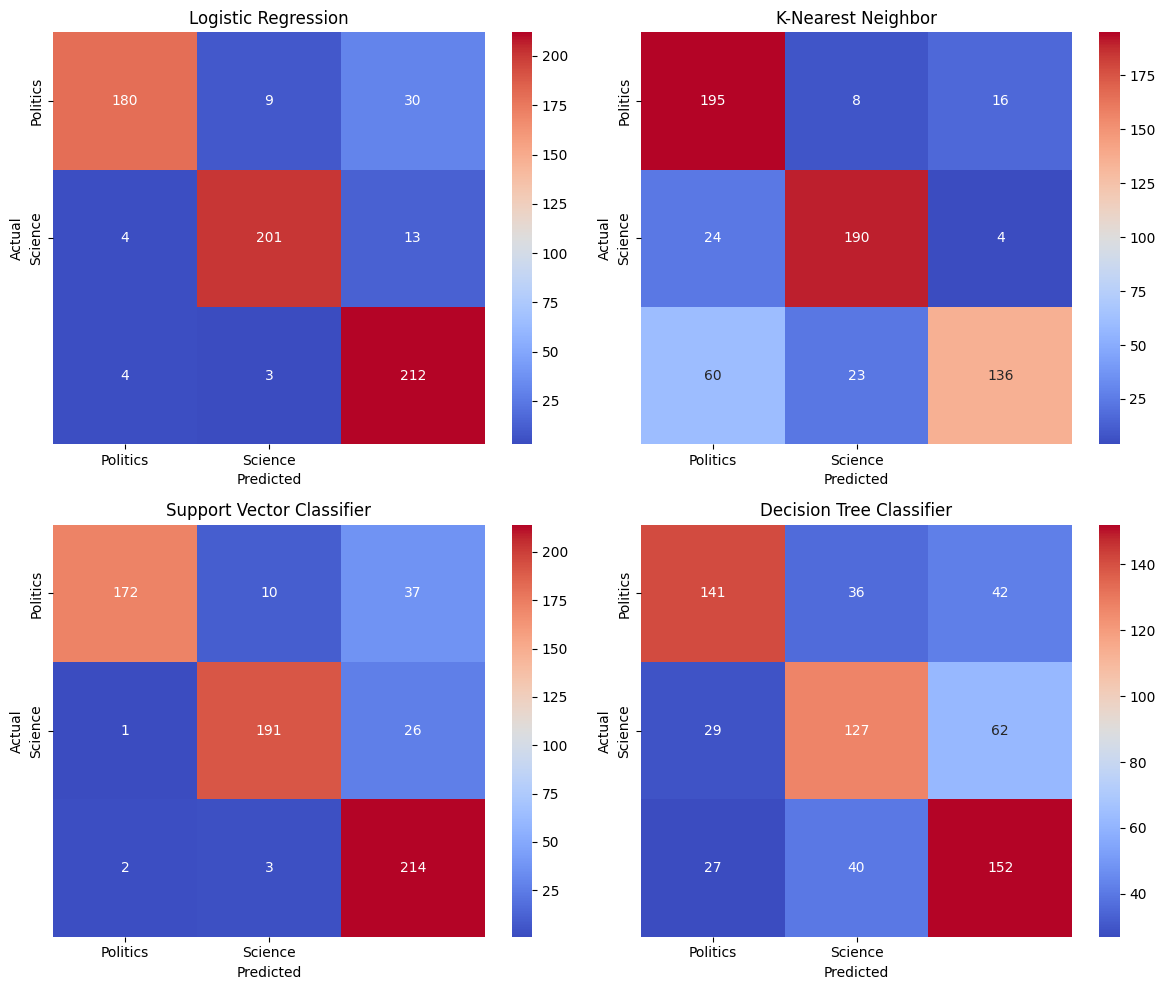

In [15]:
labels = ['Politics', 'Science']  # Altere conforme necessário para suas classes

# Configuração da figura e dos eixos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Função para plotar a matriz de confusão
def plot_confusion_matrix(ax, matrix, title):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Plotar cada matriz de confusão
plot_confusion_matrix(axs[0], log_reg_cf, 'Logistic Regression')
plot_confusion_matrix(axs[1], kneighbors_cf, 'K-Nearest Neighbor')
plot_confusion_matrix(axs[2], svc_cf, 'Support Vector Classifier')
plot_confusion_matrix(axs[3], tree_cf, 'Decision Tree Classifier')

# Ajustar layout
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Obtenha as previsões usando cross_val_predict
log_reg_pred = cross_val_predict(classifiers["LR"], X_test, y_test, cv=n_split)
knn_pred = cross_val_predict(classifiers["KNN"], X_test, y_test, cv=n_split)
svc_pred = cross_val_predict(classifiers["SVC"], X_test, y_test, cv=n_split)
tree_pred = cross_val_predict(classifiers["DT"], X_test, y_test, cv=n_split)

# Calcule as matrizes de confusão
log_reg_cf = confusion_matrix(y_test, log_reg_pred)
knn_cf = confusion_matrix(y_test, knn_pred)
svc_cf = confusion_matrix(y_test, svc_pred)
tree_cf = confusion_matrix(y_test, tree_pred)

# Labels para os heatmaps
x= ['FP','TN']
y= ['TP','FN']
colorscale = [[0, 'rgb(255,0,0)'], [1, 'rgb(0,0,255)']]

# Criação dos subplots
conf_matrix = make_subplots(rows=2, cols=2, subplot_titles=("Logistic Regression", "K-Nearest Neighbor", "Support Vector Classifier", "Decision Tree Classifier"))

# Adicionando os heatmaps
conf_matrix.add_trace(go.Heatmap(z=log_reg_cf, x=x, y=y, colorscale=colorscale, text=log_reg_cf, texttemplate="%{text}", textfont={"size":20}), row=1, col=1)
conf_matrix.add_trace(go.Heatmap(z=knn_cf, x=x, y=y, colorscale=colorscale, text=knn_cf, texttemplate="%{text}", textfont={"size":20}, showscale=False), row=1, col=2)
conf_matrix.add_trace(go.Heatmap(z=svc_cf, x=x, y=y, colorscale=colorscale, text=svc_cf, texttemplate="%{text}", textfont={"size":20}, showscale=False), row=2, col=1)
conf_matrix.add_trace(go.Heatmap(z=tree_cf, x=x, y=y, colorscale=colorscale, text=tree_cf, texttemplate="%{text}", textfont={"size":20}, showscale=False), row=2, col=2)

# Atualiza os eixos e mostra o gráfico
conf_matrix.update_yaxes(autorange="reversed")
conf_matrix.update_layout(title_text='Confusion Matrices for Classifiers')
conf_matrix.show()